# Assignment 2

**Name:** Doruk Kilitçioğlu  
**Student ID:** 2012400183

In [295]:
%matplotlib inline
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
import seaborn

## 1) Importance Sampling

Let $V$ define the area of the p-norm ball in 2D. Since the 2D p-norm balls have symmetry over $x$ and $y$ axes, we can define $V=4V_I$ where $V_I$ denotes the volume of p-norm ball that lies in quadrant $I$. The naive method of area estimation would be using Monte Carlo Integration by sampling $x \sim \mathcal{U}(0,1)$ and $y \sim \mathcal{U}(0,1)$ and doing a rejection sampling for the first quadrant p-norm ball. Instead we can use importance sampling with the proposal of exponential sampling for both x and y independently with $\lambda = 5$.

We need to estimate $V_I = \int_\Omega H(x,y)dxdy$ where $\Omega = [0,1]x[0,1]$ and $H(x,y)$ is the function defining the area we want, which is in this case an indicator function that returns 1 if $x^p+y^p\le 1$, and 0 otherwise. Due to this fact, what we are doing is not too different from rejection sampling, with a bit of extra.
The Monte Carlo estimation for this integral is
$$Q_N\equiv \frac{1}{N}\sum_{i=1}^{N}\frac{H(x_i,y_i)}{p(x_i,y_i)} $$
where $p(x_i,y_i) = p(x_i)p(y_i)$ since the samples are independent.

In [296]:
N = 1000

def indicator(x,y,p):
    return np.absolute(x)**p + np.absolute(y)**p <= 1

def sample_exp(N, lam = 5):
    return -np.log(np.random.rand(N))/lam
p = 0.5
lam = 5
x = sample_exp(N)
y = sample_exp(N)
Hx = indicator(x,y,p)
px = (lam**2*np.exp(-lam*x)*np.exp(-lam*y))
qn = np.sum(Hx/px) / N_1
print('Qn=',qn)

Qn= 0.164251664102


The area $V$ we want is simply $4Q_N$.

In [297]:
print('V=',4*qn)

V= 0.657006656409


We can see that this value is close to the the actual area of $V_{actual}=\frac{2}{3}$.

The variance of the sampled population is estimated by the sample variance, which is
$$\sigma^2_N=\frac{1}{N-1}\sum_{i=1}^N(\frac{H(x_i,y_i)}{p(x_i,y_i)}-\mu)^2$$
where $$\mu=\frac{1}{N}\sum_{i=1}^N(\frac{H(x_i,y_i)}{p(x_i,y_i)})$$ is the sample mean.

The variance of the estimate is given by
$$Var(Q_N)=Vol^2\frac{\sigma^2_N}{N}$$
where $Vol$ is the volume covered by $\Omega$, which is simply $1$ for this case.

In [298]:
mean = np.mean(Hx/px)
var_sample = (1/(N-1)) * np.sum((Hx/px - mean)**2)
print('Variance of sample population:',var_sample)
var_qn = var_sample / N
print('Variance of the estimate:',var_qn)

Variance of sample population: 0.044686142465
Variance of the estimate: 4.4686142465e-05


The formulas used above are available at [Wikipedia](https://en.wikipedia.org/wiki/Monte_Carlo_integration) in their general forms.
## 2) Markov Chains
### 2.a) Transition matrix
The transition matrix is hand-calculated from the given dice.

In [299]:
A = np.matrix([[0.25, 0.25, 0.25,    0,    0, 0.25], # side 1
               [   0, 0.25, 0.25,    0, 0.25, 0.25],
               [   0, 0.25,    0,  0.5,    0, 0.25],
               [   0, 0.25,  0.5,    0,    0, 0.25],
               [   0, 0.25, 0.25,    0, 0.25, 0.25],
               [0.25, 0.25, 0.25,    0,    0, 0.25]]).T

print(A)

[[ 0.25  0.    0.    0.    0.    0.25]
 [ 0.25  0.25  0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.    0.5   0.25  0.25]
 [ 0.    0.    0.5   0.    0.    0.  ]
 [ 0.    0.25  0.    0.    0.25  0.  ]
 [ 0.25  0.25  0.25  0.25  0.25  0.25]]


### 2.b) Stationary Distribution
We calculate the stationary distribution by calculating the right eigenvector corresponding to the eigenvalue of 1.

In [300]:
eva, evec = LA.eig(A)
i = np.argmax(np.isclose(eva, 1.0))
v = np.squeeze(np.asarray(evec[:,i]))
v = v / sum(v)
print('Stationary distribution for x in [1,6]:',v)

Stationary distribution for x in [1,6]: [ 0.08333333  0.25        0.22222222  0.11111111  0.08333333  0.25      ]


Stationary distribution is not uniform.

### 2.c) Detailed balance condition
In order for detailed balance condition to hold, the $A\pi$ matrix must be symmetrical over the diagonal at t (same as saying $A_{ji}\pi_i = A_{ij}\pi_j$ must hold).

In [301]:
x = np.multiply(A, v)
np.isclose(x, x.T).all()

False

### 2.d) Calculating the mix time
We calculate $T_{mix}$ by looking at the total variation distance between $\pi$ and $A^t\pi_0$, continuing until the difference is smaller than $\epsilon = 10^{-8}$. Note that we use their logarithms so that the code is scalable for even smaller $\epsilon$.

In [302]:
def total_variation_distance(v1, v2):
    return np.sum(np.absolute(v1 - v2)) / 2

def mix_time(A, init_pi, v_stationary, eps = float(1e-8)):
    t_mix = 0
    log_tvd = 0
    log_eps = np.log(float(1e-8))
    At = np.identity(len(A))
    while log_tvd > log_eps:
        t_mix += 1
        At = At * A
        log_tvd = np.log(total_variation_distance(At*init_pi, v_stationary))
    return t_mix

init_pi = np.matrix([1,0,0,0,0,0]).T
v_t = np.matrix(v).T
t_mix = mix_time(A, init_pi,v_t)
print('Mix time:',t_mix)

Mix time: 24


### 2.e) Verification of convergence
We visualize $A^t$ for $t = \{1,3,7, T_{mix}-1, T_{mix}\}$ to see its convergence.

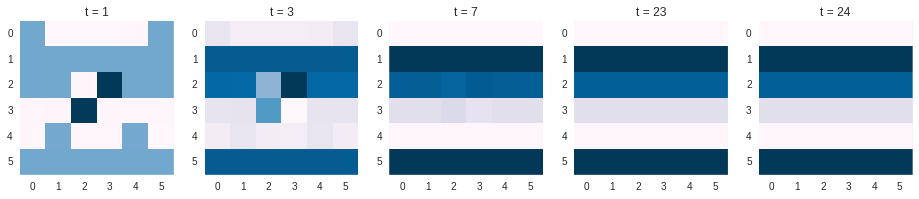

In [303]:
ts = [1,3,7,t_mix-1, t_mix]
f, subplot = plt.subplots(1,len(ts), figsize=(16,5))
for i in range(len(ts)):
    subplot[i].imshow(A ** ts[i], aspect = 'equal', interpolation='none', cmap = 'PuBu')
    subplot[i].set_title('t = '+str(ts[i]))
    subplot[i].grid(False)

We verify the mixing time by plotting $A^t\pi_0$ for $0\lt t\le T_{mix}$.

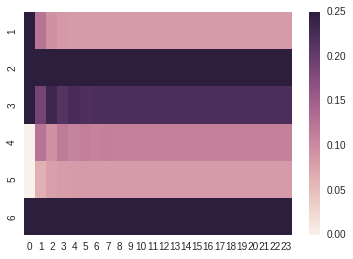

In [304]:
At = np.identity(len(A))

A_plt = np.zeros((len(A),t_mix))
for i in range(0,t_mix):
    At = At * A
    A_plt[:,i] = np.array((At * init_pi).T)[0]

seaborn.heatmap(A_plt, yticklabels=range(1,7))

### 2.f) Independent samples
In order to generate completely independent samples from the desired distribution, we start the chain *N* times and get the $X^n_t$ where $t = T_{mix}$ for $0\lt n\le N$. We then plot the distribution of these samples at different *t*. Note that the generated values are actually in [0,5] with each number $i$ pointing to the dice side with $i+1$ value.

Distribution at t=T_mix: [ 0.086  0.242  0.219  0.104  0.082  0.267]


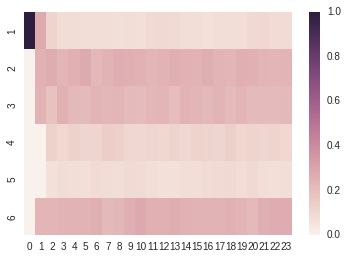

In [305]:
N = 1000
np.random.seed(N)
def sim_chain(A, i_end):
    chain = np.zeros(i_end, dtype = np.int)
    chain[0] = 0
    for i in range(1,i_end):
        pr = np.squeeze(np.asarray(A[:, chain[i-1]]))
        chain[i] = np.random.choice(range(6), p = pr)
    return chain
    
samples = np.zeros((N,t_mix), dtype = np.int)
for i in range(0, N):
    samples[i,:] = sim_chain(A, t_mix)

xx = np.apply_along_axis(lambda x: np.histogram(x, bins = [0,1,2,3,4,5,6], density = True)[0], 0, samples)
seaborn.heatmap(xx, yticklabels=range(1,7))
print('Distribution at t=T_mix:',xx[:,-1])

The colors are easier to see when plotted starting from $t=2$ since the probability of $X_t=1$ is always 1, which is never again reached after $t=1$.

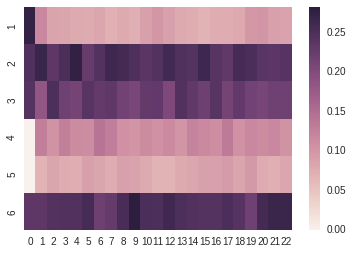

In [306]:
seaborn.heatmap(xx[:,1:], yticklabels=range(1,7))

### 2.g) Single chain dependent samples
We simulate the chain for $T_{mix} + N$ steps, and discard the first $T_{mix}$ steps.

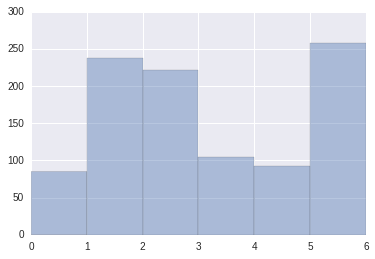

In [307]:
chain = sim_chain(A, t_mix+N)
nburnin = t_mix
seaborn.distplot(chain[nburnin:], kde = False, bins = [0,1,2,3,4,5,6])

To easily see whether this histogram agrees with the intended probability distribution, we calculate their total variation distance.

In [308]:
px = np.bincount(chain[nburnin:].astype(int))
px = px / np.sum(px)
print('Expected probabilities:',v)
print('Single chain probabilities:',px)
print('Total variation distance:',total_variation_distance(v,px))

Expected probabilities: [ 0.08333333  0.25        0.22222222  0.11111111  0.08333333  0.25      ]
Single chain probabilities: [ 0.085  0.237  0.222  0.105  0.093  0.258]
Total variation distance: 0.0193333333333


We see that the variation between the expected probabilities and the dependent samples from a single chain is very low, and as such, it is a strong indication that these samples are coming from the same distribution.